#Importa√ß√£o das Bibliotecas
Carrega bibliotecas que s√£o ferramentas de trabalho para:

- Manipular dados (pandas, numpy)

- Fazer gr√°ficos (matplotlib, seaborn)

- Construir modelos de machine learning (sklearn)

Bibliotecas espec√≠ficas ser√£o importandas ao longo do script

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
import os
import shap

# Coleta de Dados
Vamos fazer o download da base de dados e armazen√°-la em um DataFrame.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 456k/456k [00:00<00:00, 46.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/adilshamim8/student-depression-dataset/versions/1


In [ ]:
# Lista todos os arquivos e diret√≥rios baixados
dataset_name = os.listdir(path)[0]
print(os.listdir(path))

['student_depression_dataset.csv']


##Criar o DataFrame

In [ ]:
# Cria√ß√£o do dataframe
df_dataset = pd.read_csv(os.path.join(path, dataset_name))

#An√°lise Explorat√≥ria dos Dados - 1a Parte
Esta primeira an√°lise explorat√≥ria tem por objetivo conhecer os dados brutos e verificar a necessidade de transforma√ß√µes.

##Tipo dos Dados

In [ ]:
print(df_dataset.dtypes)

id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
Depression                                 int64
dtype: object


## Estat√≠stica	Descritiva
A an√°lise descritiva √© a primeira etapa da an√°lise de dados, e tem como objetivo resumir, organizar e entender as principais caracter√≠sticas de um conjunto de dados de forma simples e objetiva, sem tirar conclus√µes causais ou fazer previs√µes.

* count:	N√∫mero de valores n√£o nulos (n√£o NaN)
* mean:	M√©dia aritm√©tica dos valores
* std:	Desvio padr√£o (medida de dispers√£o)
* min:	Valor m√≠nimo
* 25%:	Primeiro quartil (Q1) ‚Äì 25% dos dados est√£o abaixo desse valor
* 50%:	Mediana (Q2) ‚Äì metade dos dados est√£o abaixo desse valor
* 75%:	Terceiro quartil (Q3) ‚Äì 75% dos dados est√£o abaixo desse valor
* max:	Valor m√°ximo

In [ ]:
df_dataset.describe()

id           Age  Academic Pressure  Work Pressure  \
count   27901.000000  27901.000000       27901.000000   27901.000000   
mean    70442.149421     25.822300           3.141214       0.000430   
std     40641.175216      4.905687           1.381465       0.043992   
min         2.000000     18.000000           0.000000       0.000000   
25%     35039.000000     21.000000           2.000000       0.000000   
50%     70684.000000     25.000000           3.000000       0.000000   
75%    105818.000000     30.000000           4.000000       0.000000   
max    140699.000000     59.000000           5.000000       5.000000   

               CGPA  Study Satisfaction  Job Satisfaction  Work/Study Hours  \
count  27901.000000        27901.000000      27901.000000      27901.000000   
mean       7.656104            2.943837          0.000681          7.156984   
std        1.470707            1.361148          0.044394          3.707642   
min        0.000000            0.000000          0.000000          0.000000   
25%        6.290000            2.000000          0.000000          4.000000   
50%        7.770000            3.000000          0.000000          8.000000   
75%        8.920000            4.000000          0.000000         10.000000   
max       10.000000            5.000000          4.000000         12.000000   

         Depression  
count  27901.000000  
mean       0.585499  
std        0.492645  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

In [ ]:
dep = df_dataset['Depression'].value_counts().reset_index()
dep.columns = ['Depressao', 'Quantidade']
print(dep)

   Depressao  Quantidade
0          1       16336
1          0       11565


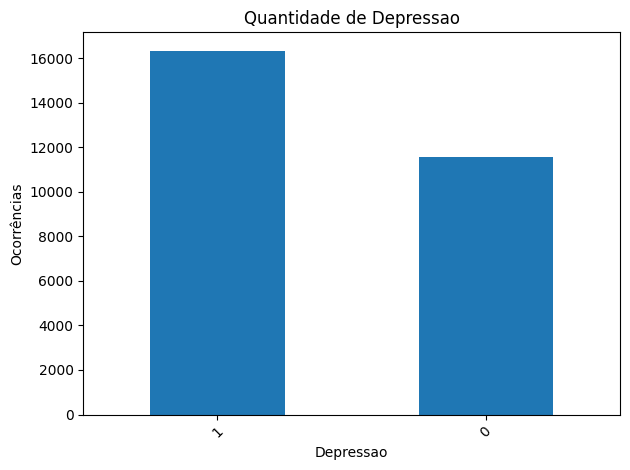

In [ ]:
df_dataset['Depression'].value_counts().plot(kind='bar')
plt.title('Quantidade de Depressao')
plt.xlabel('Depressao')
plt.ylabel('Ocorr√™ncias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Total Com Depress√£o x Sem Depress√£o

In [ ]:
# Total de registros no DataFrame
total_registros = len(df_dataset)

# Soma diagnostico de depressao
total_nao_dep = dep[dep['Depressao'] == 0]['Quantidade'].sum()

# Soma apenas as dep (exclui no depressao(0))
total_dep = dep[dep['Depressao'] != 0]['Quantidade'].sum()

# Calcula a porcentagem
percentual_nao_dep = (total_nao_dep / total_registros) * 100
percentual_dep = (total_dep / total_registros) * 100

# Exibe o resultado
print(f"Total de registros.: {total_registros}")
print(f"Total de sem depressao: {total_nao_dep} ou {percentual_nao_dep:.2f}% do total")
print(f"Total de depressao....: {total_dep} ou {percentual_dep:.2f}% do total")


Total de registros.: 27901
Total de sem depressao: 11565 ou 41.45% do total
Total de depressao....: 16336 ou 58.55% do total


#Engenharia de Dados

##Eliminar Valores Nulos
A elimina√ß√£o de valores nulos dever√° ser feita com cuidados. √â necess√°rio avaliar a real necessidade de elimin√°-los, pois h√° alternativas, por exemplo, substituir os valores faltantes pela moda ou pela m√©dia.

In [ ]:
df_dataset.isnull().sum()

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

N√£o h√° dados nulos

##Eliminar as Linhas Duplicadas
J√° sabemos que n√£o h√° duplica√ß√£o, ent√£o, este passo n√£o seria necess√°rio, mas fica a t√≠tulo de exemplo

#Cabe√ßalho com coluna 'Sleep Duration' formatada

Tirar o 'hours' e substituir 'Less than' por '<' e 'More than' por '>'.

In [ ]:
formated_sleep_duration = df_dataset['Sleep Duration'].str.replace("'", "").str.strip('hours').str.replace(r'^Less than', '<', regex=True).str.replace(r'^More than', '>', regex=True)
df_dataset['Sleep Duration'] = formated_sleep_duration

df_dataset.head()

id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction Sleep Duration  \
0            0.0  8.97                 2.0               0.0           5-6    
1            0.0  5.90                 5.0               0.0           5-6    
2            0.0  7.03                 5.0               0.0           < 5    
3            0.0  5.59                 2.0               0.0           7-8    
4            0.0  8.13                 3.0               0.0           5-6    

  Dietary Habits   Degree Have you ever had suicidal thoughts ?  \
0        Healthy  B.Pharm                                   Yes   
1       Moderate      BSc                                    No   
2        Healthy       BA                                    No   
3       Moderate      BCA                                   Yes   
4       Moderate   M.Tech                                   Yes   

   Work/Study Hours Financial Stress Family History of Mental Illness  \
0               3.0              1.0                               No   
1               3.0              2.0                              Yes   
2               9.0              1.0                              Yes   
3               4.0              5.0                              Yes   
4               1.0              1.0                               No   

   Depression  
0           1  
1           0  
2           0  
3           1  
4           0

#Rodap√© com coluna 'Sleep Duration' formatada

Tirar o 'hours' e substituir 'Less than' por '<' e 'More than' por '>'.

In [ ]:
formated_sleep_duration = df_dataset['Sleep Duration'].str.replace("'", "").str.strip('hours').str.replace(r'^Less than', '<', regex=True).str.replace(r'^More than', '>', regex=True)
df_dataset['Sleep Duration'] = formated_sleep_duration

df_dataset.tail()

id  Gender   Age       City Profession  Academic Pressure  \
27896  140685  Female  27.0      Surat    Student                5.0   
27897  140686    Male  27.0   Ludhiana    Student                2.0   
27898  140689    Male  31.0  Faridabad    Student                3.0   
27899  140690  Female  18.0   Ludhiana    Student                5.0   
27900  140699    Male  27.0      Patna    Student                4.0   

       Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
27896            0.0  5.75                 5.0               0.0   
27897            0.0  9.40                 3.0               0.0   
27898            0.0  6.61                 4.0               0.0   
27899            0.0  6.88                 2.0               0.0   
27900            0.0  9.24                 1.0               0.0   

      Sleep Duration Dietary Habits      Degree  \
27896           5-6       Unhealthy  'Class 12'   
27897           < 5         Healthy         MSc   
27898           5-6       Unhealthy          MD   
27899           < 5         Healthy  'Class 12'   
27900           < 5         Healthy         BCA   

      Have you ever had suicidal thoughts ?  Work/Study Hours  \
27896                                   Yes               7.0   
27897                                    No               0.0   
27898                                    No              12.0   
27899                                   Yes              10.0   
27900                                   Yes               2.0   

      Financial Stress Family History of Mental Illness  Depression  
27896              1.0                              Yes           0  
27897              3.0                              Yes           0  
27898              2.0                               No           0  
27899              5.0                               No           1  
27900              3.0                              Yes           1

In [ ]:
# Quantidade total antes
total_antes = len(df_dataset)

# Quantidade de duplicadas
duplicadas = df_dataset.duplicated().sum()

# Remover duplicadas
df_dataset = df_dataset.drop_duplicates()

# Quantidade total depois
total_depois = len(df_dataset)

print(f"Total de linhas antes......................: {total_antes}")
print(f"Linhas duplicadas detectadas...............: {duplicadas}")
print(f"Total de linhas depois do drop_duplicates(): {total_depois}")

Total de linhas antes......................: 27901
Linhas duplicadas detectadas...............: 0
Total de linhas depois do drop_duplicates(): 27901


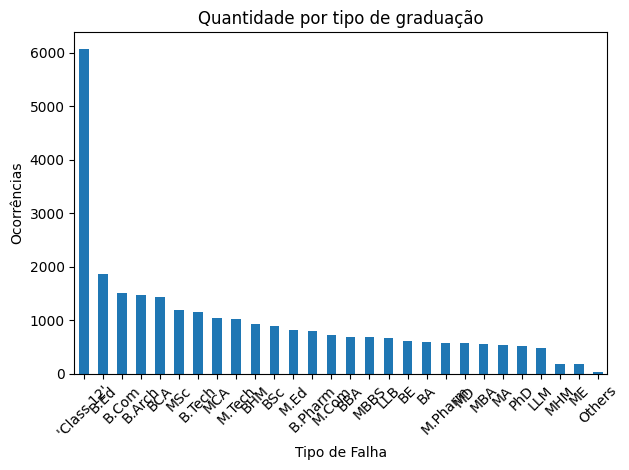

In [ ]:
#Exibe um gr√°fico da quantidade de falhas por 'Failure Code'
df_dataset['Degree'].value_counts().plot(kind='bar')
plt.title('Quantidade por tipo de gradua√ß√£o')
plt.xlabel('Tipo de Falha')
plt.ylabel('Ocorr√™ncias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#An√°lise Explorat√≥ria dos Dados - 2a Parte
N√£o h√° necessidade de repetir os comando da 1a Parte, pois n√£o houve mudan√ßa dos dados (nenhum valor nulo, por exemplo). Ent√£o, vamos aproveitar para fazer mais an√°lises e gr√°ficos

##Histogramas das Vari√°veis Num√©ricas

* O **histograma** (barras) mostra a **frequ√™ncia** de registros em faixas espec√≠ficas de temperatura do ar.
* A **linha azul** representa a **curva de densidade estimada** ‚Äî ela suaviza os dados e mostra como os valores est√£o concentrados.
* O eixo **X** mostra a temperatura do ar em Kelvin.
* O eixo **Y** mostra quantas amostras est√£o em cada faixa de temperatura.

### *Interpreta√ß√£o:*

Vamos fazer para o primeiro. Convido voc√™ a fazer para os demais.

| Observa√ß√£o                                                      | Significado                                                                       |
| --------------------------------------------------------------- | --------------------------------------------------------------------------------- |
| A maior parte dos dados est√° entre **297K e 303K**              | Temperaturas de opera√ß√£o t√≠picas ficam nessa faixa (\~24¬∞C a 30¬∞C)                |
| A distribui√ß√£o tem v√°rios **picos** (multimodal)                | Pode haver grupos de m√°quinas ou momentos distintos de opera√ß√£o                   |
| Existe uma **simetria moderada**, com leve inclina√ß√£o √† direita | Mostra que h√° **alguns casos com temperaturas mais altas**, mas sem grande desvio |

### *Rela√ß√£o com falhas:*

Apesar de ser uma vari√°vel bem distribu√≠da e aparentemente "est√°vel", sabemos por an√°lises anteriores (como boxplots e pairplots) que:

* **Falhas como Heat Dissipation Failure** tendem a ocorrer quando a temperatura do ar est√° **acima de 302K**.
* Isso pode ser confirmado visualmente nesse gr√°fico: a ‚Äúcauda direita‚Äù da curva (temperaturas maiores) √© menos frequente, mas **potencialmente cr√≠tica**.


### *Resultado:*

Este gr√°fico mostra como a temperatura do ar varia na nossa base. A maioria das medi√ß√µes est√° concentrada perto dos 300K (cerca de 27¬∞C), o que parece ser uma condi√ß√£o normal. Mas h√° alguns casos onde a temperatura √© mais alta, e foi justamente nessas faixas que algumas falhas apareceram, como problemas de dissipa√ß√£o de calor.

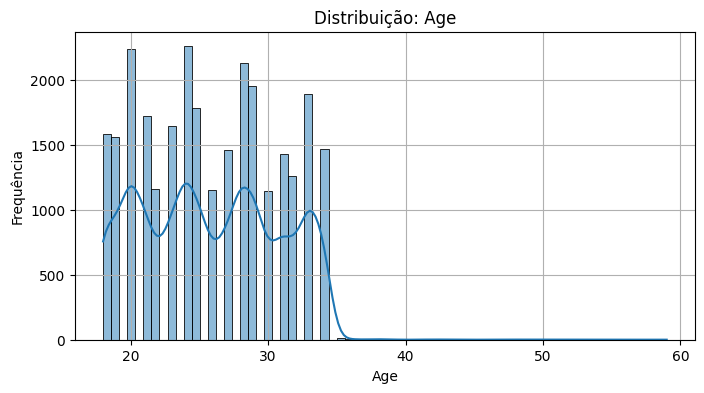

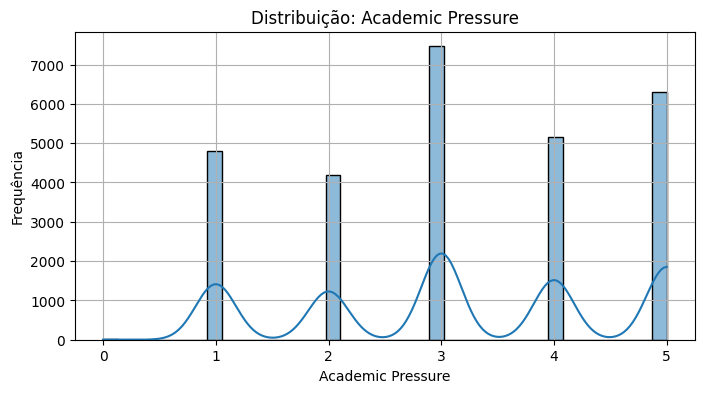

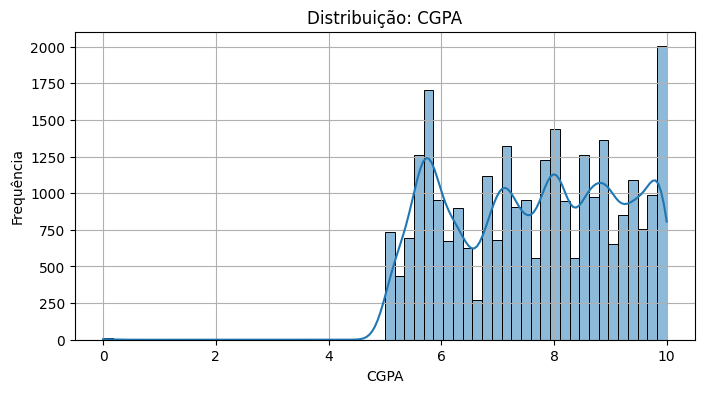

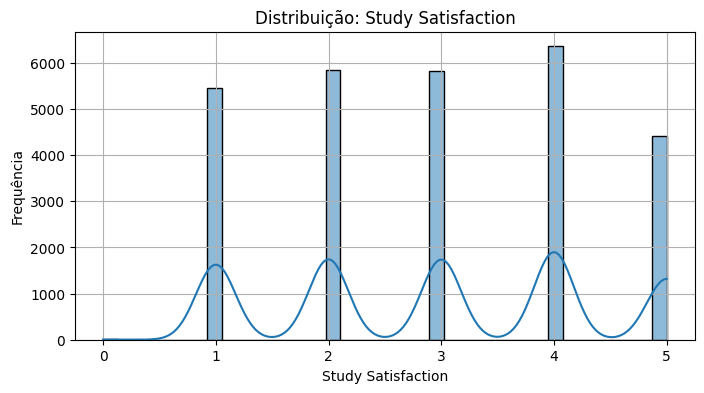

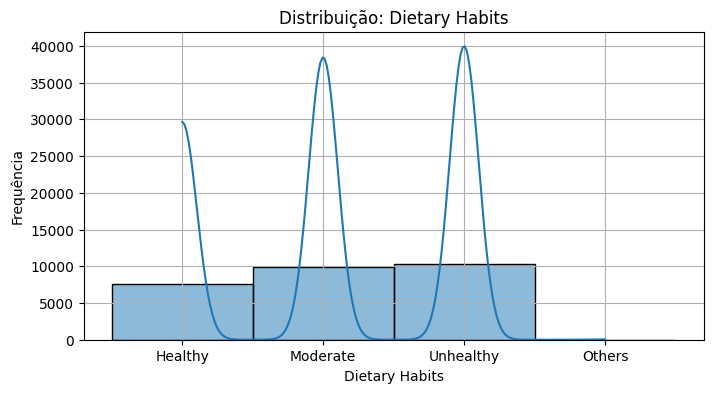

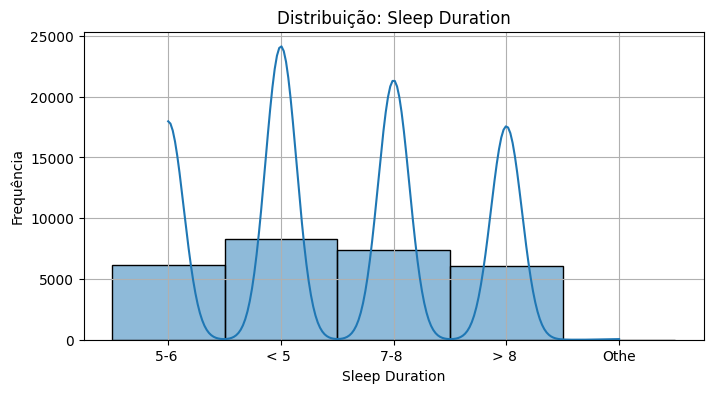

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

variaveis = ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Dietary Habits', 'Sleep Duration']

for var in variaveis:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_dataset[var], kde=True)
    plt.title(f'Distribui√ß√£o: {var}')
    plt.xlabel(var)
    plt.ylabel("Frequ√™ncia")
    plt.grid(True)
    plt.show()


##Pairplot

Esse gr√°fico compara **todas as vari√°veis num√©ricas duas a duas**, usando dispers√£o (scatterplots) e densidade (diagonal). Ele √© segmentado por **tipo de falha (`Failure Type`)**, usando **cores diferentes para cada classe**.

Esse gr√°fico mostra se h√° agrupamentos naturais de pontos (falhas) com base em combina√ß√µes de vari√°veis. Isso pode mostrar, por exemplo, que falhas de "Power Failure" acontecem com baixa rota√ß√£o e alto torque.

### *Eixos:*

* Linhas = vari√°vel no eixo Y
* Colunas = vari√°vel no eixo X
* Diagonal = distribui√ß√£o (densidade) de cada vari√°vel


### *Distribui√ß√µes diagonais (autocorrelacionadas)*

* As curvas mostram a **distribui√ß√£o dos valores por vari√°vel**.
* Por exemplo, a maioria dos valores de `Torque` est√° entre **35 e 55 Nm**, mas com **alguns pontos acima de 70** ‚Üí outliers possivelmente relacionados a falhas.

### *Padr√µes de falha por cor (fora da diagonal)*

| Vari√°veis comparadas          | O que se observa?                                                                                       |
| ----------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Air Temp √ó Process Temp**   | Correla√ß√£o quase perfeita (esperado fisicamente)                                                        |
| **Torque √ó Rotational Speed** | Rela√ß√£o inversa clara (quando torque sobe, rota√ß√£o tende a cair ‚Äî tamb√©m esperado)                      |
| **Torque √ó Failure Type**     | üî• Falhas (especialmente Power Failure e Tool Wear Failure) **concentradas em regi√µes com torque alto** |
| **Tool Wear √ó Torque/Speed**  | Algumas falhas ocorrem com **desgaste elevado e torque alto**                                           |

### *O que chama aten√ß√£o?*

* **Power Failure (laranja)** aparece muito mais em regi√µes com **alta rota√ß√£o** e **alto torque** ‚Üí padr√£o cr√≠tico de opera√ß√£o extrema.
* **Tool Wear Failure (verde)** ocorre em regi√µes de **torque alto + desgaste alto**.
* **Heat Dissipation Failure (roxo)** aparece onde a **temperatura do ar √© mais alta**.
* A classe **"No Failure" (azul)** est√° **muito espalhada**, cobrindo quase todo o gr√°fico ‚Üí normal, pois √© a classe dominante.

Esse gr√°fico mostra como as vari√°veis se comportam em pares e como os diferentes tipos de falha se distribuem nesses espa√ßos. Por exemplo, falhas de desgaste ocorrem quando o torque e o desgaste est√£o altos. J√° falhas de dissipa√ß√£o de calor acontecem quando a temperatura do ar √© maior. Esse tipo de visualiza√ß√£o nos ajuda a entender que tipo de combina√ß√£o de condi√ß√µes pode levar a uma falha.


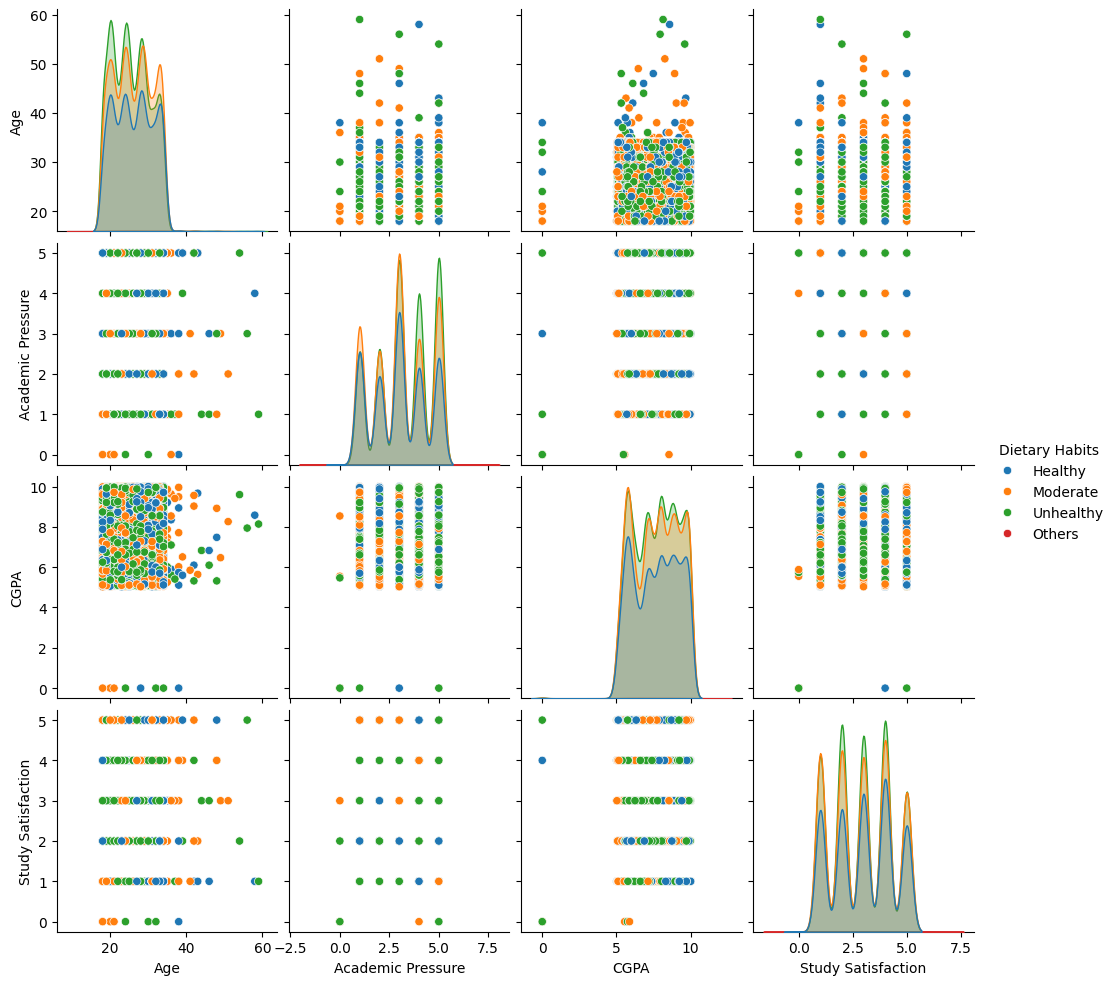

In [32]:
vars_numericas = [c for c in variaveis if pd.api.types.is_numeric_dtype(df_dataset[c])]

sns.pairplot(df_dataset, hue="Dietary Habits", vars=vars_numericas)

##Boxplots

Um boxplot (gr√°fico de caixa) **resume a distribui√ß√£o de valores** em cinco partes:

* **Linha central (mediana)**: valor do meio
* **Caixa**: intervalo entre o 1¬∫ quartil (25%) e o 3¬∫ quartil (75%)
* **‚ÄúBigodes‚Äù (linhas finas)**: mostram a faixa de valores dentro de 1,5x a amplitude interquartil (IQR)
* **Pontos fora da caixa** (se houver): s√£o considerados **outliers**

### *O que este gr√°fico mostra?*

Vamos fazer a an√°lise somente para o primeiro gr√°fico. Convido voc√™ a fazer para os demais.

Ele compara a temperatura do ar entre os diferentes **tipos de falha**:

| Tipo de Falha                | Observa√ß√£o sobre Temperatura                                            |
| ---------------------------- | ----------------------------------------------------------------------- |
| **No Failure**               | Mediana \~300K, dispers√£o normal                                        |
| **Power Failure**            | Similar a ‚ÄúNo Failure‚Äù, talvez um pouco mais quente                     |
| **Tool Wear Failure**        | Tamb√©m pr√≥ximo de 300K, sem destaque claro                              |
| **Overstrain Failure**       | Levemente mais fria que as demais                                       |
| **Random Failures**          | Varia mais, tem uma mediana levemente mais alta                         |
| **Heat Dissipation Failure** | üìå **Temperatura claramente mais alta** (\~302‚Äì304K) e mais concentrada |


### Interpreta√ß√£o pr√°tica*

* A temperatura do ar **n√£o varia muito entre os tipos de falha** ‚Äî a maioria fica em torno de **300 K (\~27 ¬∞C)**.
* A exce√ß√£o √© a **Heat Dissipation Failure**, que ocorre com **temperaturas consistentemente mais altas**.

  * Isso faz **sentido f√≠sico**, j√° que o nome indica falha no resfriamento ‚Üí ar mais quente ao redor do sistema.


### *Resultado*

Este gr√°fico mostra que, na maioria dos tipos de falha, a temperatura do ar n√£o muda muito. Mas no caso de falha de dissipa√ß√£o de calor, o ar est√° claramente mais quente. Isso pode indicar que o sistema est√° retendo calor e n√£o est√° conseguindo resfriar direito ‚Äî o que ajuda a entender esse tipo de falha.

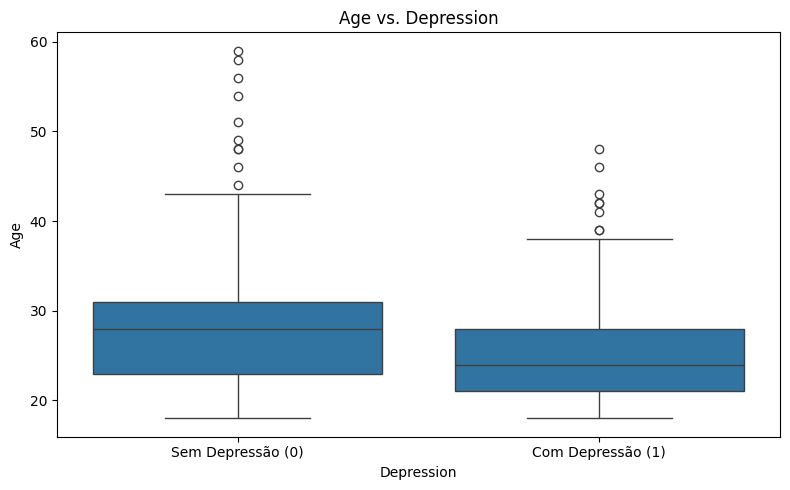

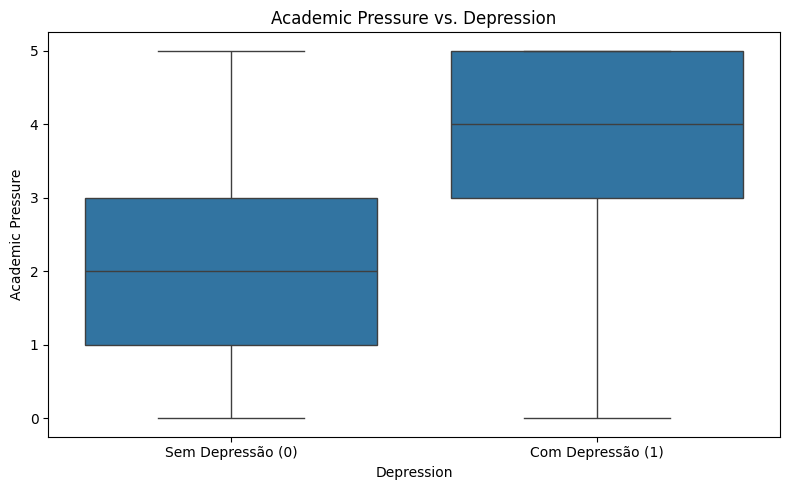

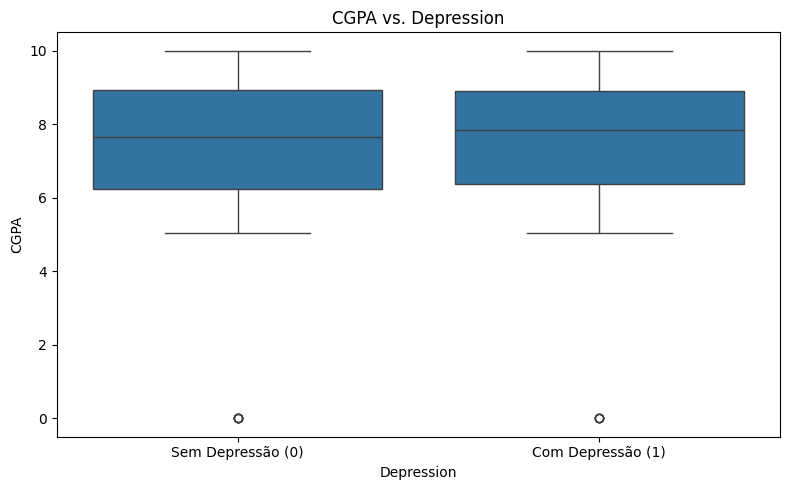

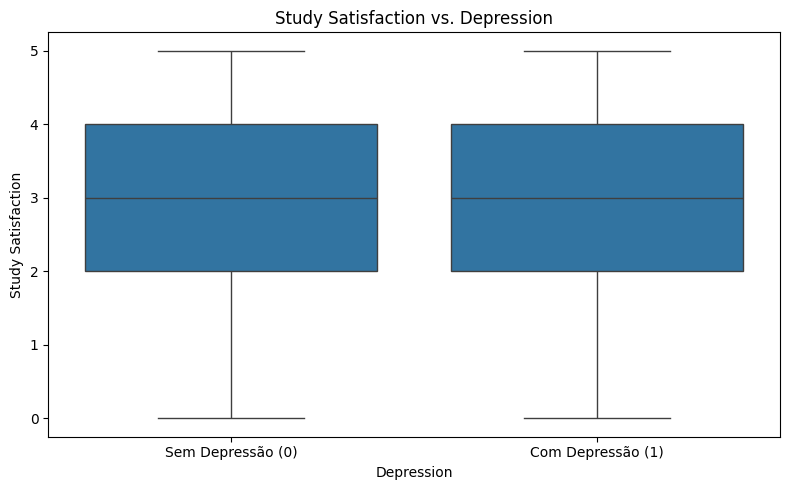

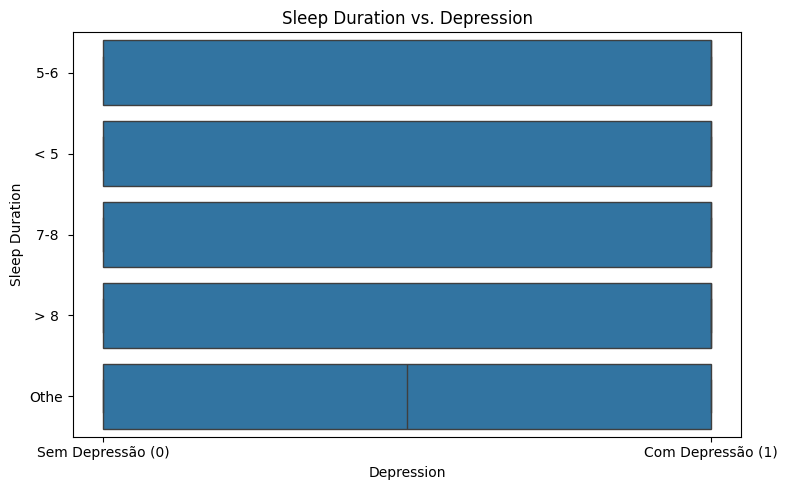

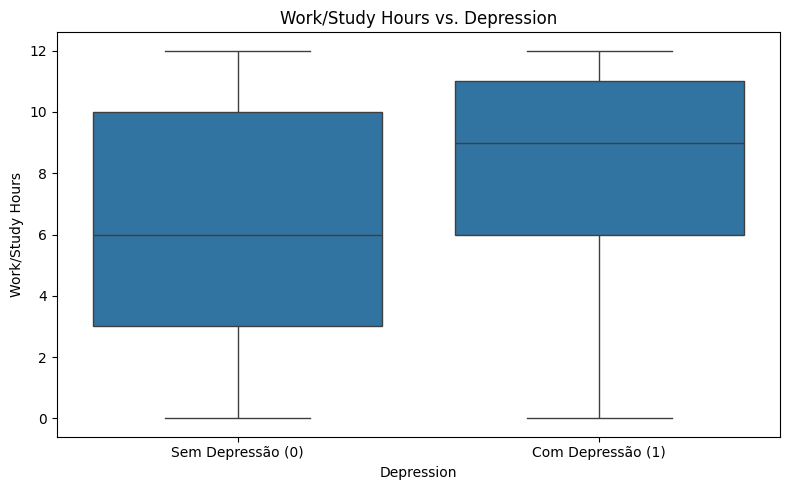

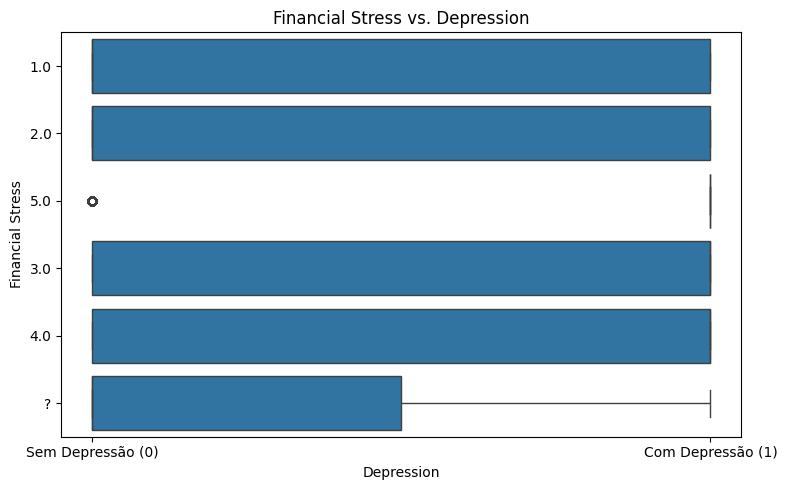

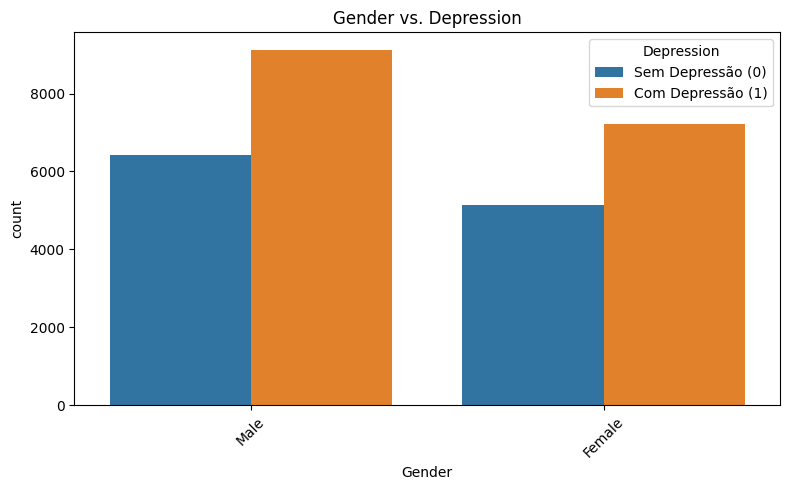

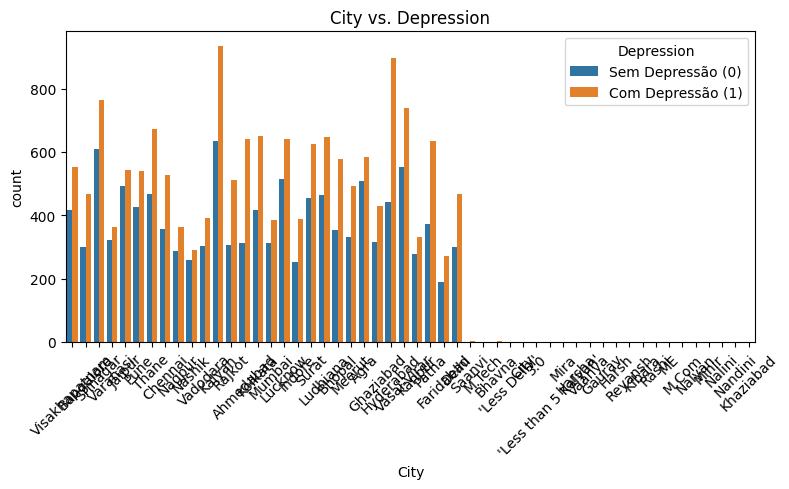

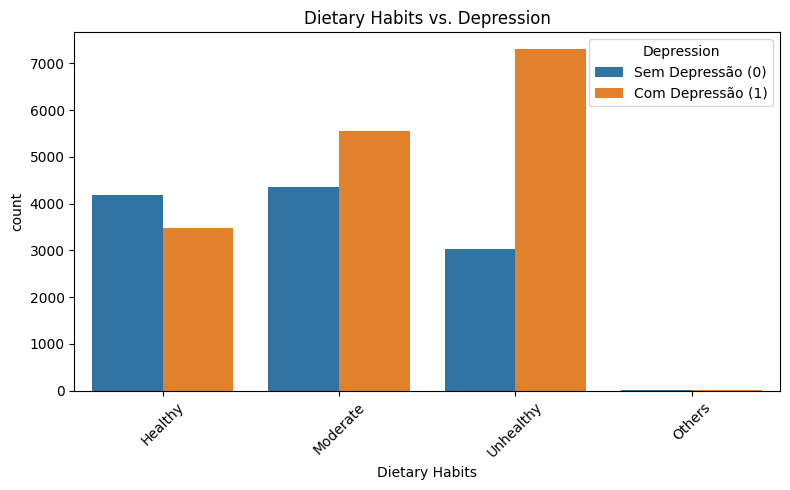

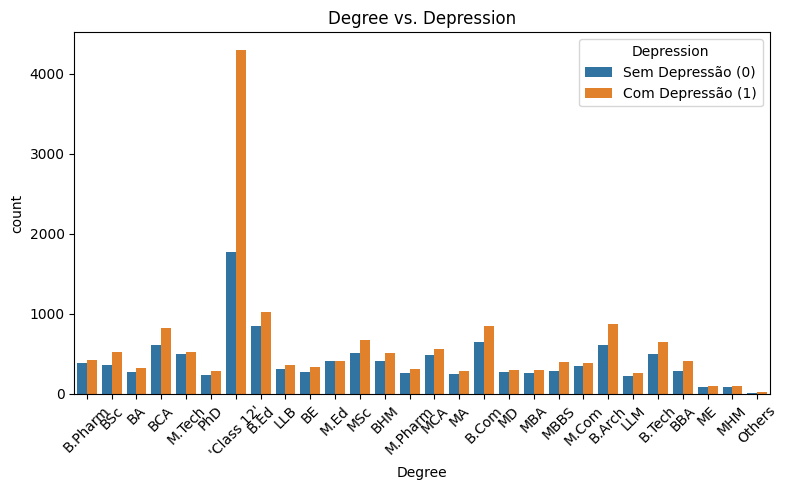

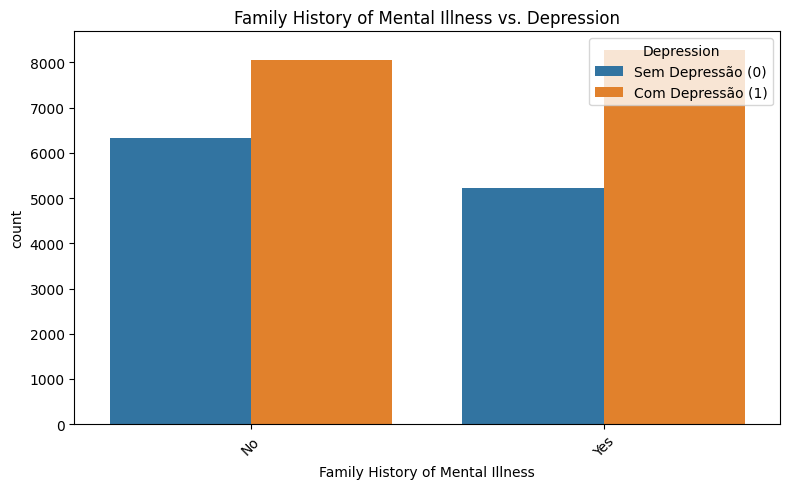

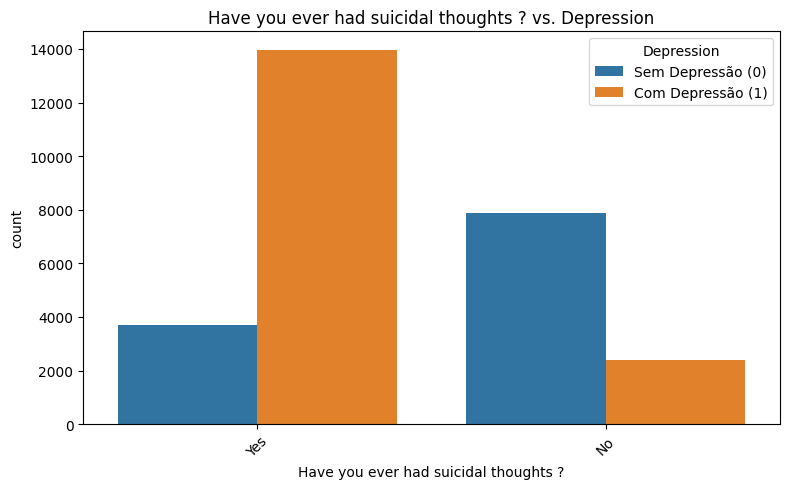

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# BOXPlots - vari√°veis num√©ricas
# ===============================
variaveis_numericas = [
    'Age',
    'Academic Pressure',
    'CGPA',
    'Study Satisfaction',
    'Sleep Duration',
    'Work/Study Hours',
    'Financial Stress'
]

for var in variaveis_numericas:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_dataset, x='Depression', y=var)
    plt.title(f'{var} vs. Depression')
    plt.xticks([0, 1], ['Sem Depress√£o (0)', 'Com Depress√£o (1)'])
    plt.tight_layout()
    plt.show()


# ===============================
# COUNTPLOTS - vari√°veis categ√≥ricas
# ===============================
variaveis_categoricas = [
    'Gender',
    'City',
    'Dietary Habits',
    'Degree',
    'Family History of Mental Illness',
    'Have you ever had suicidal thoughts ?'
]

for var in variaveis_categoricas:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_dataset, x=var, hue='Depression')
    plt.title(f'{var} vs. Depression')
    plt.xticks(rotation=45)
    plt.legend(title="Depression", labels=["Sem Depress√£o (0)", "Com Depress√£o (1)"])
    plt.tight_layout()
    plt.show()



## Matriz de Correla√ß√£o Completa (Mapa de Calor)

A **matriz de correla√ß√£o de Pearson** mede o **grau de rela√ß√£o linear** entre pares de vari√°veis.

* Valores pr√≥ximos de **1** = rela√ß√£o linear positiva forte
* Valores pr√≥ximos de **‚àí1** = rela√ß√£o linear negativa forte
* Valores pr√≥ximos de **0** = pouca ou nenhuma rela√ß√£o linear


### *Correla√ß√µes interessantes entre as vari√°veis*

| Par de vari√°veis              | Correla√ß√£o | O que isso diz                                                                                                     |
| ----------------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------ |
| **Air temp ‚Üî Process temp**   | +0.88      | Andam juntas ‚Äî provavelmente aumentam ao mesmo tempo                                                               |
| **Torque ‚Üî Rotational speed** | ‚àí0.88      | Rela√ß√£o **fortemente inversa**: quanto mais torque, menor a rota√ß√£o (ou vice-versa) ‚Äî isso faz sentido fisicamente |
| **Outros pares**              | ‚âà 0        | Pouca rela√ß√£o direta entre outras vari√°veis                                                                        |

### *Como isso se conecta √† √°rvore de decis√£o?*

* **Mesmo que a correla√ß√£o seja baixa**, a √°rvore **ainda pode usar essas vari√°veis** para fazer boas divis√µes ‚Äî pois a √°rvore **n√£o depende apenas de rela√ß√µes lineares**.
* Por exemplo:

  * **Torque e Rotational speed** t√™m correla√ß√£o negativa forte entre si, mas **podem ser √∫teis em ramos distintos da √°rvore**.

### *Resultado*

Este mapa de calor mostra rela√ß√µes entre as vari√°veis, n√£o com falhas. Em manuten√ß√£o preditiva, ele revela co-varia√ß√µes e redund√¢ncias (multicolinearidade) e inspira features derivadas. Depois, modelos n√£o lineares (como √°rvores) capturam padr√µes e intera√ß√µes que a correla√ß√£o linear n√£o mostra ‚Äî lembre: correla√ß√£o ‚â† causalidade.

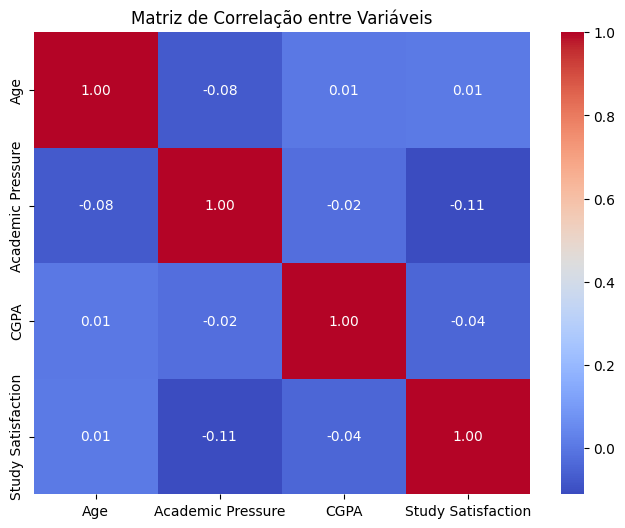

In [ ]:
corr_matrix = df_dataset[variaveis].corr(numeric_only=True)

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correla√ß√£o entre Vari√°veis')
plt.show()

##Matriz de Correla√ß√£o entre as Vari√°veis e o a Falha

Esse √© um **gr√°fico de barras horizontais** que mostra o **coeficiente de correla√ß√£o** entre cada vari√°vel e o tipo de falha (codificado numericamente).

Mostra a for√ßa e dire√ß√£o de uma rela√ß√£o linear entre cada vari√°vel e a vari√°vel alvo (Failure_Code).

√â global e linear: ele verifica se uma vari√°vel aumenta ou diminui √† medida que o tipo de falha muda (em m√©dia).

Valores pr√≥ximos de zero indicam que a vari√°vel isoladamente n√£o tem uma rela√ß√£o linear forte com a falha.

* **Correla√ß√£o positiva** ‚Üí conforme o valor da vari√°vel aumenta, √© mais prov√°vel que ocorra um certo tipo de falha (classes maiores).
* **Correla√ß√£o negativa** ‚Üí conforme o valor da vari√°vel aumenta, a chance de falha diminui ou muda para outro tipo de falha (classes menores).
* **Pr√≥ximo de zero** ‚Üí pouca ou nenhuma rela√ß√£o linear direta com o tipo de falha.

### *Interpreta√ß√£o do gr√°fico*

| Vari√°vel                | Correla√ß√£o com a falha | Interpreta√ß√£o pr√°tica                                                                      |
| ----------------------- | ---------------------- | ------------------------------------------------------------------------------------------ |
| **Tool wear \[min]**    | **+0.11**              | Quanto mais desgastada a ferramenta, **maior a chance de falha** (forte indicador).        |
| **Torque \[Nm]**        | +0.03                  | Torque alto est√° **levemente associado** a tipos de falhas.                                |
| **Rotational speed**    | ‚âà 0.00                 | **Praticamente sem correla√ß√£o linear** com a falha.                                        |
| **Process temperature** | **‚àí0.01**              | Pequena correla√ß√£o negativa, praticamente irrelevante.                                     |
| **Air temperature**     | **‚àí0.02**              | Um leve ind√≠cio de que temperaturas mais altas do ar podem estar ligadas a falhas menores. |


### *Como interpretar isso?*

* A √∫nica vari√°vel com **correla√ß√£o not√°vel √© `Tool wear`**: isso faz sentido, pois ferramentas muito desgastadas tendem a quebrar ou falhar.
* O restante tem **baixa ou nenhuma correla√ß√£o linear direta**. Isso n√£o significa que s√£o in√∫teis ‚Äî apenas que a rela√ß√£o pode ser **n√£o linear** ou **mais complexa**, e por isso √© melhor capturada por modelos como √°rvores.

### *Resultado*

Esse gr√°fico mostra que, dentre todas as vari√°veis, o desgaste da ferramenta √© o que mais influencia o tipo de falha. Ou seja, quanto mais usada a ferramenta, mais prov√°vel que aconte√ßa uma falha grave. J√° a rota√ß√£o ou a temperatura n√£o t√™m um efeito direto e simples, mas isso n√£o quer dizer que n√£o importam ‚Äî o modelo pode estar captando intera√ß√µes mais complexas entre elas.


Top pares por |correla√ß√£o|:
                                      Par  abs_corr
4  Study Satisfaction ‚Üî Academic Pressure  0.110988
0                 Academic Pressure ‚Üî Age  0.075803
5               Study Satisfaction ‚Üî CGPA  0.044062
2                CGPA ‚Üî Academic Pressure  0.022239
3                Study Satisfaction ‚Üî Age  0.009235
1                              CGPA ‚Üî Age  0.005056


/tmp/ipython-input-2507585602.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pairs['Par'] = top_pairs['Var 1'] + ' ‚Üî ' + top_pairs['Var 2']
/tmp/ipython-input-2507585602.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs, x='abs_corr', y='Par', orient='h', palette='coolwarm')


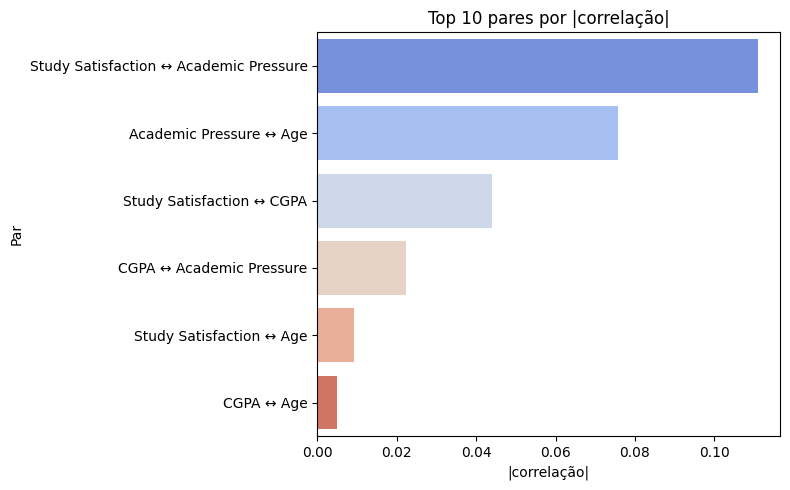

In [ ]:
corr = df_dataset[variaveis].corr(numeric_only=True).abs()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr_tri = corr.where(~mask)

pairs = (
    corr_tri.stack()
    .reset_index()
    .rename(columns={'level_0':'Var 1', 'level_1':'Var 2', 0:'abs_corr'})
    .sort_values('abs_corr', ascending=False)
)

top_k = 10
top_pairs = pairs.head(top_k)
top_pairs['Par'] = top_pairs['Var 1'] + ' ‚Üî ' + top_pairs['Var 2']

print("Top pares por |correla√ß√£o|:")
print(top_pairs[['Par', 'abs_corr']])

plt.figure(figsize=(8, 5))
sns.barplot(data=top_pairs, x='abs_corr', y='Par', orient='h', palette='coolwarm')
plt.title(f'Top {top_k} pares por |correla√ß√£o|')
plt.xlabel('|correla√ß√£o|')
plt.tight_layout()
plt.show()